In [1]:
import matplotlib.pyplot as plt
import sys
import tensornetwork as tn
import scipy as sp
sys.path.insert(0,'..')

import numpy as np
import time_evolving_mpo as tempo


In [2]:
# # generate the process tensor and save to file
# omega_cutoff = 3.04 
# alpha = 0.126
# temperature = 0.1309 # 1K = 0.1309/ps 

# correlations = tempo.PowerLawSD(alpha=alpha, 
#                                 zeta=3, 
#                                 cutoff=omega_cutoff, 
#                                 cutoff_type='gaussian', 
#                                 max_correlation_time=5.0,
#                                 temperature=temperature)
# bath = tempo.Bath(tempo.operators.sigma("z")/2.0, correlations)

# pt_tempo_parameters = tempo.PtTempoParameters(dt=0.05, dkmax=20, epsrel=10**(-4))

# process_tensor = tempo.pt_tempo_compute(bath=bath,
#                                         start_time=-2.0,
#                                         end_time=3.0,
#                                         parameters=pt_tempo_parameters)


# process_tensor.export("details_pt_tempo_dt0p05.processTensor",overwrite=True)

In [3]:
# import the process tensor as an adjoint pt and set up the system
pt = tempo.import_adjoint_process_tensor('details_pt_tempo_dt0p02.processTensor','adjoint')

delta=0.0

initial_state=tempo.operators.spin_dm("z-")

def gaussian_shape(t, area = 1.0, tau = 1.0, t_0 = 0.0):
    return area/(tau*np.sqrt(np.pi)) * np.exp(-(t-t_0)**2/(tau**2))

def hamiltonian_t(t, delta=delta): 
        return delta/2.0 * tempo.operators.sigma("z") \
            + gaussian_shape(t-2.5, area = np.pi/2.0, tau = 0.245)/2.0 * tempo.operators.sigma("x") 

system = tempo.TimeDependentSystem(hamiltonian_t)


In [4]:
# compute the dynamics using normal PT-TEMPO code for comparison
dynamics = pt.compute_dynamics_from_system(
        system=system, 
        initial_state=initial_state)
t, s_x = dynamics.expectations(tempo.operators.sigma("x"), real=True)
_, s_y = dynamics.expectations(tempo.operators.sigma("y"), real=True)
_, s_z = dynamics.expectations(tempo.operators.sigma("z"), real=True)
s_xy = np.sqrt(s_x**2 + s_y**2)

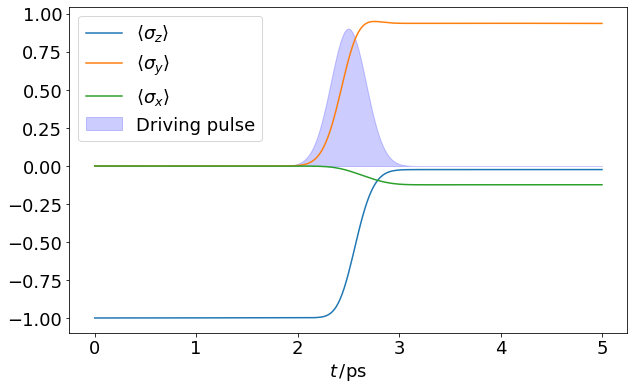

In [5]:

Omega_t = gaussian_shape(t-2.5, area = np.pi/2.0, tau = 0.245)
#plt.plot(t,Omega_t/4.0,label=r"Driving pulse")

plt.rc('font',size=18)
plt.figure(figsize=(10,6))
plt.fill_between(t, Omega_t/4.0, 0,
                 facecolor="orange", # The fill color
                 color='blue',       # The outline color
                 alpha=0.2,label=r"Driving pulse")  

plt.plot(t,s_z,label=r"$\langle\sigma_z\rangle$")
plt.plot(t,s_y,label=r"$\langle\sigma_y\rangle$")
plt.plot(t,s_x,label=r"$\langle\sigma_x\rangle$")
plt.xlabel(r"$t\,/\mathrm{ps}$")
#plt.ylabel(r"$\mathrm{ps}^{-1}$")
plt.legend()
plt.savefig("test2.png",format="png")


In [6]:
# compute the dynamics and the gradients with respect to the Liouville-space propagators
# using the adjoint code
derivlist,final_state = pt.compute_derivatives_from_system(system,initial_state=np.array([[0,0],[0,1]]),target_state = tempo.operators.spin_dm("y+"))


ValueError: too many values to unpack (expected 2)

In [ ]:
times = 0.0 + np.arange(len(pt.forwards)/2)*pt.dt


In [ ]:
import itertools 

In [ ]:
# to convert the derivatives w.r.t. the propagators into derivatives with respect to a term in Hamiltonian
# we use the fact that dF/dr= sum a,b dF/dU_a,b dU_a,b/dr.
# so I need the derivatives of the U (system propagators in Liouville space) w.r.t. control parameter
# Here is a simple centred-finite difference calculation, with step h
# for the case where we want dF/dr with r the prefactor of op in the Hamiltonian
def dpropagator(system,t,dt,op,h):
    temp=h
    h=temp
    ham=system.hamiltonian
    post_liouvillian_plush=-1j * tempo.util.commutator(ham(t+dt*3.0/4.0)+h*op)
    post_liouvillian_minush=-1j * tempo.util.commutator(ham(t+dt*3.0/4.0)-h*op)
    post_propagator_plush=sp.linalg.expm(post_liouvillian_plush*dt/2.0).T
    post_propagator_minush=sp.linalg.expm(post_liouvillian_minush*dt/2.0).T
    postderiv=(post_propagator_plush-post_propagator_minush)/(2.*h)    
    pre_liouvillian_plush=-1j * tempo.util.commutator(ham(t+dt*1.0/4.0)+h*op)
    pre_liouvillian_minush=-1j * tempo.util.commutator(ham(t+dt*1.0/4.0)-h*op)
    pre_propagator_plush=sp.linalg.expm(pre_liouvillian_plush*dt/2.0).T
    pre_propagator_minush=sp.linalg.expm(pre_liouvillian_minush*dt/2.0).T
    prederiv=(post_propagator_plush-post_propagator_minush)/(2.*h)  
    return prederiv,postderiv

# construct the derivatives of propagators with 
def dpropagatorlist(system,times,dt,op,h=1e-6):
    derivlist=[]
    for step in range(len(times)):
        prederiv,postderiv=dpropagator(system,times[step],dt,op,h)
        derivlist.append(prederiv)
        derivlist.append(postderiv)
    return derivlist

def combinederivs(target_derivatives,propagator_derivatives):
    assert (len(target_derivatives)==len(propagator_derivatives)), "Lists supplied have uneqal length"
    derivvalslist=[]
    for (target_deriv,propagator_deriv) in zip(target_derivatives,propagator_derivatives):
        # I need to check I've got these indices the right way
        # here's the tensornetwork version
        #dtargetnode=tn.Node(target_deriv)
        #dpropnode=tn.Node(propagator_deriv)
        #dtargetnode[0] ^ dpropnode[0]
        #dtargetnode[1] ^ dpropnode[1]
        #derivvalslist.append((dtargetnode @ dpropnode).tensor+0.0)
        # if the above is right it can also be done like this
        derivvalslist.append(np.matmul(target_deriv,propagator_deriv).trace())
    return derivvalslist
        
def allproptimes(times,dt):
    return np.array([[t+dt/4.0,t+dt*3.0/4.0] for t in times]).flatten()

In [ ]:
# functions to evaluate the density matrix at the half steps
# probably destructive of the tensor networks contained in proctens.forwards, 

def densmatlist(proctens):
    fplist=proctens.forwards
    resultlist=[]
    print(len(fplist)//2)
    cap=tn.Node(proctens.get_cap_tensor(0))
    for i in range(len(fplist)//2):
        curr=fplist[2*i]
        curr[0] ^ cap[0]
        result=curr @ cap
        resultlist.append(result.tensor.reshape((2,2)))
        cap=tn.Node(proctens.get_cap_tensor(i+1))
        curr=fplist[2*i+1]
        curr[0] ^ cap[0]
        result=curr @ cap
        resultlist.append(result.tensor.reshape((2,2)))
    return resultlist



In [ ]:
dpropsz=dpropagatorlist(system,times,pt.dt,np.array([[1.0,0.0],[0.0,-1.0]]))
dpropsx=dpropagatorlist(system,times,pt.dt,np.array([[0.0,1.0],[1.0,0.0]]))
dpropsy=dpropagatorlist(system,times,pt.dt,np.array([[0.0,-1.0j],[1.0j,0.0]]))

In [ ]:
szderivs=combinederivs(dpropsz,derivlist)
sxderivs=combinederivs(dpropsx,derivlist)
syderivs=combinederivs(dpropsy,derivlist)

In [ ]:
preposttimes=allproptimes(times,pt.dt)

/usr/lib/python3/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


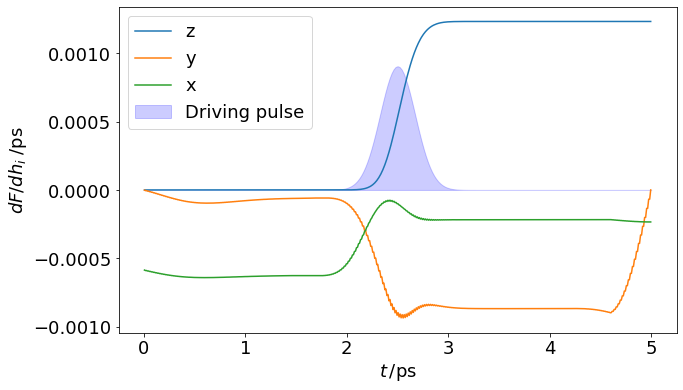

In [ ]:

Omega_t = gaussian_shape(t-2.5, area = np.pi/2.0, tau = 0.245)
#plt.plot(t,Omega_t/4.0,label=r"Driving pulse")

plt.rc('font',size=18)
plt.figure(figsize=(10,6))
plt.fill_between(t, Omega_t/4000.0, 0,
                 facecolor="orange", # The fill color
                 color='blue',       # The outline color
                 alpha=0.2,label=r"Driving pulse")  

plt.plot(preposttimes,szderivs,label=r"z")
plt.plot(preposttimes,syderivs,label=r"y")
plt.plot(preposttimes,sxderivs,label=r"x")
plt.xlabel(r"$t\,/\mathrm{ps}$")
plt.ylabel(r"$dF/dh_i\;/\mathrm{ps}$")
plt.legend()
plt.savefig("test.png",format="png")


250


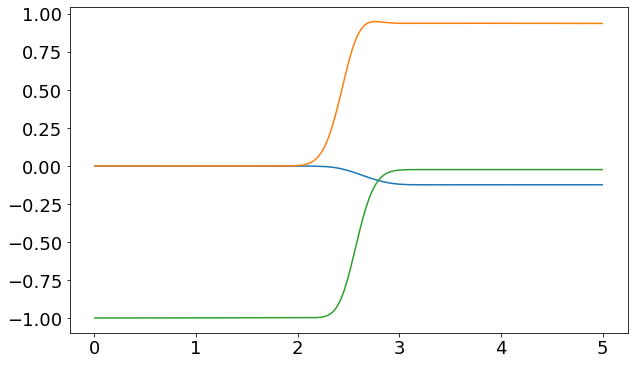

In [ ]:
# plot the expectations on the half-steps 
# this might be destructive of the data stored in pt.forwards
rdm=densmatlist(pt)
op=np.array([[1.0,0.0],[0.0,-1.0]])
szexps=list(map(lambda x: (np.matmul(x,op).trace()),rdm))
op=np.array([[0.0,-1.0j],[1.0j,0.0]])
syexps=list(map(lambda x: (np.matmul(x,op).trace()),rdm))
op=np.array([[0.0,1.0],[1.0,0.0]])
sxexps=list(map(lambda x: (np.matmul(x,op).trace()),rdm))

plt.rc('font',size=18)
plt.figure(figsize=(10,6))
plt.plot(preposttimes,sxexps)
plt.plot(preposttimes,syexps)
plt.plot(preposttimes,szexps)


In [ ]:
# hmm. that looks good but here are some checks. what happens if we turn off dissipation
pt = tempo.import_adjoint_process_tensor('details_pt_tempo_nobath.processTensor','adjoint')


In [ ]:
# compute the dynamics and the gradients with respect to the Liouville-space propagators
# using the adjoint code
derivlist,final_state,_ = pt.compute_derivatives_from_system(system,initial_state=np.array([[0,0],[0,1]]),target_state = np.array([[1,0],[0,0]]))


In [ ]:
szderivs=combinederivs(dpropsz,derivlist)
sxderivs=combinederivs(dpropsx,derivlist)
syderivs=combinederivs(dpropsy,derivlist)

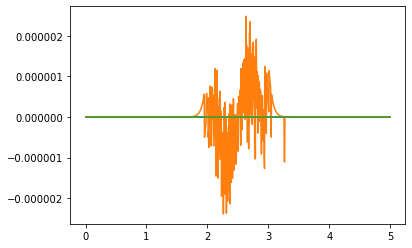

In [ ]:
plt.plot(preposttimes,szderivs)
plt.plot(preposttimes,sxderivs)
plt.plot(preposttimes,syderivs)

In [ ]:
# excellent, that looks comparable to the numerical accuracy (given h=1e-6 particularly)


In [ ]:
(np.finfo(float).eps)**(1.0/3.0) # ah ok so if i compute to a fractional accuracy of machine precision, then 6e-6 times the scale of the function is the optimal choice of h

6.055454452393343e-06

In [ ]:
a=3.017484
temp=a
a=temp
print(a)

3.017484


In [ ]:
((pt.dt)**2)**(1.0/3.0) # so don't compute the propagator approximately! this would be the optimal h otherwise.

0.046415888336127795

In [ ]:
tempo.operators.spin_dm("x+")

array([[0.5+0.j, 0.5+0.j],
       [0.5+0.j, 0.5+0.j]])

In [ ]:
# ok, back to the original thing but let's calculate the gradient wrt the fidelity to a different state
derivlist,final_state = pt.compute_derivatives_from_system(system,initial_state=np.array([[0,0],[0,1]]),target_state = tempo.operators.spin_dm("y+"))


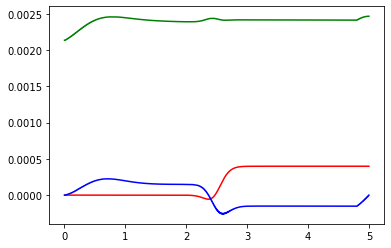

In [ ]:
szderivs=combinederivs(dpropsz,derivlist)
sxderivs=combinederivs(dpropsx,derivlist)
syderivs=combinederivs(dpropsy,derivlist)
plt.plot(preposttimes,szderivs,'r-')
plt.plot(preposttimes,sxderivs,'g-')
plt.plot(preposttimes,syderivs,'b-')

In [ ]:
plt.plot?

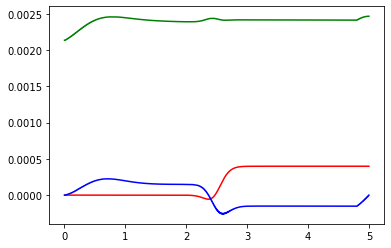

In [ ]:
szderivs=combinederivs(dpropsz,derivlist)
sxderivs=combinederivs(dpropsx,derivlist)
syderivs=combinederivs(dpropsy,derivlist)
plt.plot(preposttimes,szderivs,'r-')
plt.plot(preposttimes,sxderivs,'g-')
plt.plot(preposttimes,syderivs,'b-')

In [ ]:
# those results look good. i wonder if i can check by finite differencing?
# no that's too boring?
# perhaps not.


In [ ]:
pt.forwards[]

Node
(
name : '__unnamed_node__',
tensor : 
array([[0, 0, 0, 1]]),
edges : 
[
Edge(Dangling Edge)[0] 
, 
Edge(Dangling Edge)[1] 
] 
)

In [ ]:
pt.get_cap_tensor(1)

array([-9.98778159e-01-5.70512404e-18j, -8.78261146e-16+6.45157070e-17j,
        9.65452812e-16+5.74335110e-16j])

(1, 4)

In [ ]:
(0+1)//2

0

In [ ]:
(1+1)//2

1

100


250


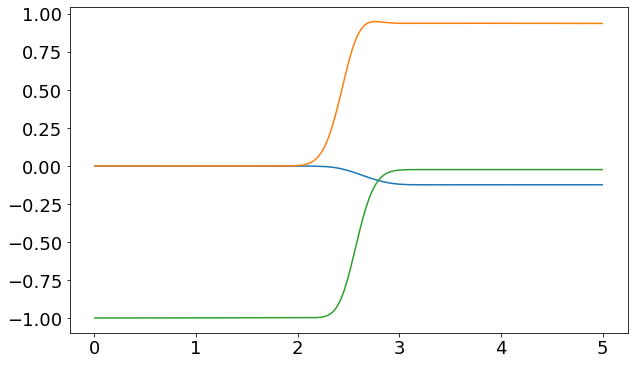

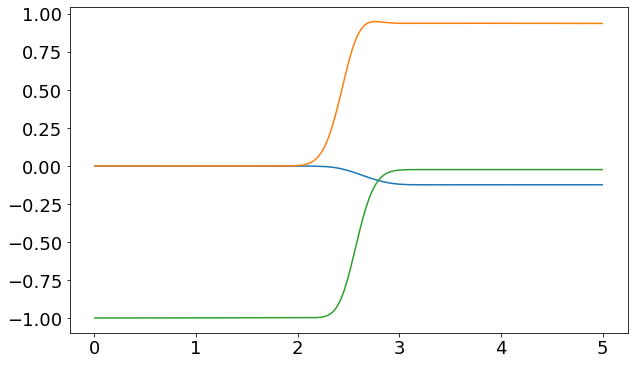

In [ ]:

#plt.plot(t,s_y)

In [ ]:
rd

500


In [ ]:
preposttimes.shape

(1000,)

In [ ]:
pt.dt

0.01

In [ ]:
pt.forwards

[Node
 (
 name : '__unnamed_node__',
 tensor : 
 array([[0, 0, 0, 1]]),
 edges : 
 [
 Edge(Dangling Edge)[0] 
 , 
 Edge(Dangling Edge)[1] 
 ] 
 ),
 Node
 (
 name : '__unnamed_node__',
 tensor : 
 array([[-2.72780947e-94+0.00000000e+00j, -2.12345330e-64+1.65132103e-47j,
         -2.11039272e-64-1.65132103e-47j, -1.00011589e+00+2.11782880e-21j],
        [-3.12832308e-94-6.53713994e-95j,  7.70104276e-48+1.05697135e-47j,
          7.70104276e-48+1.05697135e-47j,  1.14695901e+00+2.39675741e-01j],
        [ 1.46220349e-94-1.58954516e-94j,  1.92695451e-47-1.77718973e-48j,
          1.92695451e-47-1.77718973e-48j, -5.36097908e-01+5.82786077e-01j]]),
 edges : 
 [
 Edge(Dangling Edge)[0] 
 , 
 Edge(Dangling Edge)[1] 
 ] 
 ),
 Node
 (
 name : '__unnamed_node__',
 tensor : 
 array([[-2.95685420e-93-4.64132268e-113j,
         -2.12265146e-64+5.43789521e-047j,
         -2.11119456e-64-5.43789521e-047j,
         -1.00011589e+00+2.11782880e-021j],
        [ 1.33131292e-93+2.78199491e-094j,
          1